In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time
from glob import glob
import pickle

from plots_fabi import *

# import models
import sys
sys.path.append('tf_models')
from train import train
# Add functions path
sys.path.append('../Functions')

In [2]:
from datasets import load_stratified_dataset
from sklearn.model_selection import train_test_split
df = load_stratified_dataset(path='../Datasets/dataset_categories/dataset_big.csv', labels='category', samples_per_label=1000, random_seed=42)

In [3]:
# TfidfVectorizer generates bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
def tfidf_(text, category, ngram=(1,2), min_df=5):
    
    X_train, X_test, y_train, y_test = train_test_split(text, category)
    
    # sublinear_tf: use logarithmic form for frequency
    # min_df: minimum numbers of documents a word must be present to keep it
    # ngram_range: number of ngrams to use
    # stopwords: remove all common pronouns in given language

    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=min_df, norm='l2', encoding='latin-1',
                            ngram_range=ngram, stop_words='english')

    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    train_tfidf = (X_train_tfidf, y_train)
    test_tfidf = (X_test_tfidf, y_test)
    
    return train_tfidf, test_tfidf

In [5]:
def counter_(text, category, ngram=(1,2), min_df=5):
    
    X_train, X_test, y_train, y_test = train_test_split(text, category)
    
    counter = CountVectorizer(min_df=min_df, encoding='latin-1',
                              ngram_range=ngram, stop_words='english')

    X_train_count = counter.fit_transform(X_train)
    X_test_count = counter.transform(X_test)
    train_count = (X_train_count, y_train)
    test_count = (X_test_count, y_test)
    
    return train_count, test_count

### Standard

In [6]:
train_tfidf, test_tfidf = tfidf_(df.text, df.category)
train_count, test_count = counter_(df.text, df.category)

### N-grams, min_df

__Multinomial Naive Bayes__
* highest train accuracy for ngrams(2,3), min_df=5 (train:86, test:70)
* highest test accuracy for ngrams(1,3), min_df=5 (train:80, test:73)

***
# Embeddings

### Word embedding

In [7]:
from word_embeddings.vectorizer import EmbeddingVectorizer

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.text_lem, df.category, random_state=42)

In [9]:
from sklearn.svm import LinearSVC
def lin_svc(word_vectors, method, vocab_count):
    clf = LinearSVC(random_state=42, dual=False, max_iter=10000)

    train_start = time()
    clf.fit(X_train_vec, y_train)
    train_time = time() - train_start

    pred_start = time()
    test_score = clf.score(X_test_vec, y_test) * 100
    train_score = clf.score(X_train_vec, y_train) * 100
    pred_time = time() - pred_start

    return {
        'word_vectors': word_vectors,
        'method': method,
        'vocab_count': vocab_count,
        'train_acc': train_score,
        'test_acc': test_score,
        'train_time': train_time,
        'pred_time': pred_time
    }

In [11]:
with open('word_embeddings/.word_embeddings_results_broad.pickle', 'rb') as file:
    results = pickle.load(file)

In [12]:
# Add vocab size and emb dim to dictionaries
for r in results:
    r['vocab_size'] = int(r['word_vectors'].split('voc_')[1].replace('.word_vectors', '').split('_dim_')[0])
    r['emb_dim'] = int(r['word_vectors'].split('voc_')[1].replace('.word_vectors', '').split('_dim_')[1])

#### Plots

In [13]:
def get_train_test(emb_dim, method, vocab_count, name):
    
    x = [r['vocab_size'] for r in results if r['emb_dim'] == emb_dim and r['method'] == method and r['vocab_count'] == vocab_count]
    train = [r['train_acc'] for r in results if r['emb_dim'] == emb_dim and r['method'] == method and r['vocab_count'] == vocab_count]
    test = [r['test_acc'] for r in results if r['emb_dim'] == emb_dim and r['method'] == method and r['vocab_count'] == vocab_count]
    
    # Sort values
    x, train, test = zip(*sorted(zip(x, train, test)))
    
    y[name] = test
    y2[name] = train

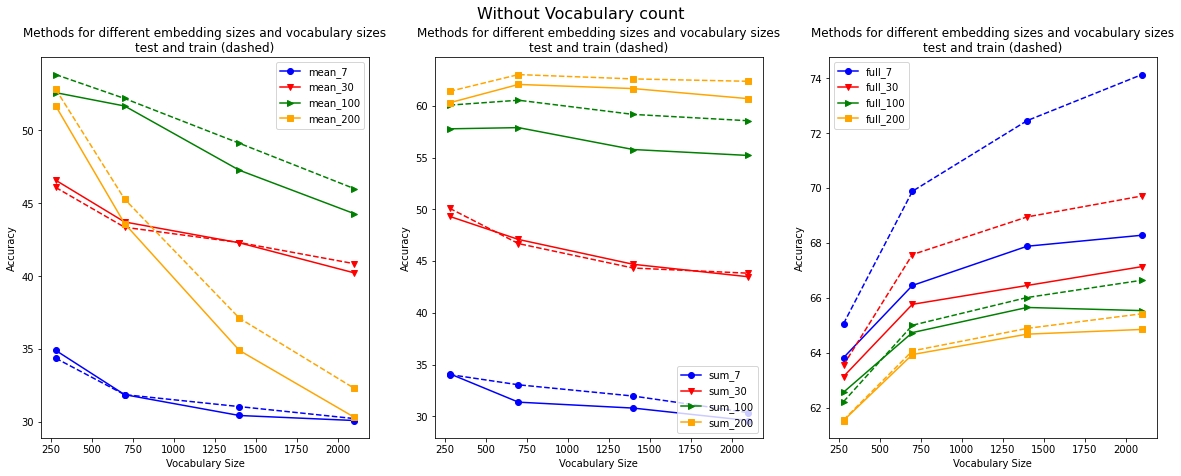

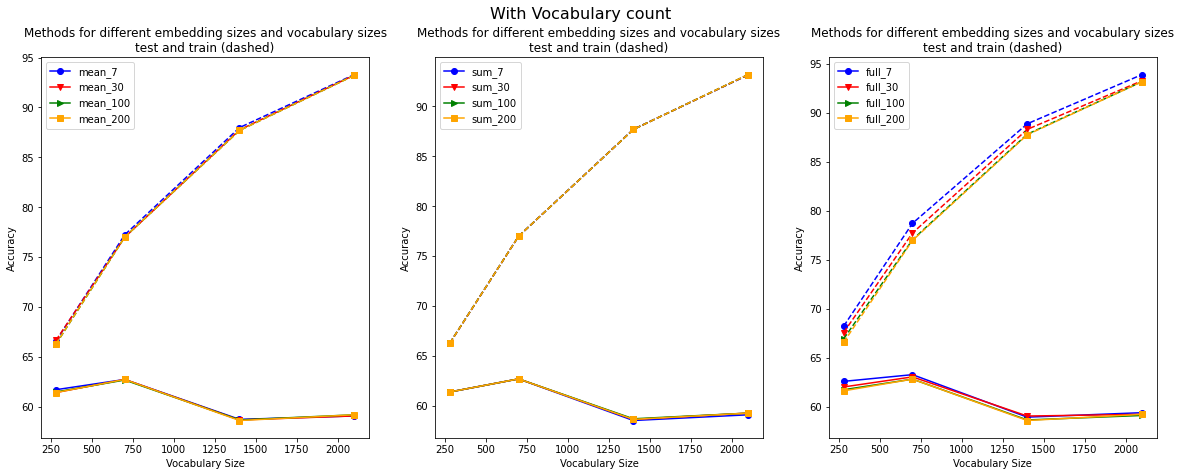

In [14]:
fig, ax = plt.subplots(1,3, figsize=(20,7))
fig.suptitle('Without Vocabulary count', fontsize=16)
count = 0
for method in ['mean', 'sum', 'full']:
    # Vocabulary count
    x = sorted([r['vocab_size'] for r in results if r['emb_dim'] == 7 and r['method'] == 'mean' and r['vocab_count'] == False])
    y = {}
    y2 = {}

    get_train_test(7, method, False, method + '_7')
    get_train_test(30, method, False, method + '_30')
    get_train_test(100, method, False, method + '_100')
    get_train_test(200, method, False, method + '_200')

    few_points_line_plot(x, y, y2=y2, ax=ax[count],
                         title='Methods for different embedding sizes and vocabulary sizes\ntest and train (dashed)',
                         xlabel='Vocabulary Size', 
                         ylabel='Accuracy')
    count += 1
    
plt.show()

fig, ax = plt.subplots(1,3, figsize=(20,7))
fig.suptitle('With Vocabulary count', fontsize=16)
count = 0
for method in ['mean', 'sum', 'full']:
    # Vocabulary count
    x = sorted([r['vocab_size'] for r in results if r['emb_dim'] == 7 and r['method'] == 'mean' and r['vocab_count'] == True])
    y = {}
    y2 = {}
    
    for emb in [7,30,100,200]:
        get_train_test(emb, method, True, method + '_' + str(emb))

    few_points_line_plot(x, y, y2=y2, ax=ax[count],
                         title='Methods for different embedding sizes and vocabulary sizes\ntest and train (dashed)',
                         xlabel='Vocabulary Size', 
                         ylabel='Accuracy')
    count += 1

* Vocabulary Count leads to strong variance
* method full seems to be better for low embedding and high vocabulary size
* method sum is best for high embedding size, and best for medium sized vocabulary
* method mean increases with lower vocabulary size, mostly for high embedding

### Test again for different options
#### Mean

In [15]:
# Loop over all word vectors
results = []
count = 1
total = int(len(glob('word_embeddings/mean_test/*')))
start = time()
vocab_count=False
for word_vectors in glob('word_embeddings/mean_test/*'):
    for method in ['mean']:
            #print(word_vectors, method, vocab_count)
            emb_vec = EmbeddingVectorizer(method=method, word_vectors=word_vectors)
            X_train_vec = emb_vec.transform(X_train)
            X_test_vec = emb_vec.transform(X_test)
            results.append(lin_svc(word_vectors, method, vocab_count))
            print('{:.2f}%'.format(count/total*100), end='\r')
            count+=1
print('finished in {:.2f}m'.format((time()-start)/60))

finished in 0.53m


In [16]:
with open('word_embeddings/.word_embeddings_results_mean.pickle', 'wb') as file:
    pickle.dump(results, file, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
with open('word_embeddings/.word_embeddings_results_mean.pickle', 'rb') as file:
    results = pickle.load(file)

In [18]:
# Add vocab size and emb dim to dictionaries
for r in results:
    r['vocab_size'] = int(r['word_vectors'].split('voc_')[1].replace('.word_vectors', '').split('_dim_')[0])
    r['emb_dim'] = int(r['word_vectors'].split('voc_')[1].replace('.word_vectors', '').split('_dim_')[1])

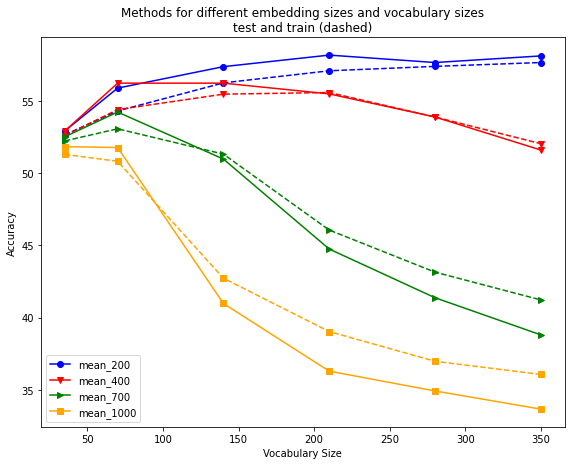

In [19]:
method='mean'

# Vocabulary count
x = sorted([r['vocab_size'] for r in results if r['emb_dim'] == 200 and r['vocab_count'] == False])
y = {}
y2 = {}

for emb in [200,400,700,1000]:
    get_train_test(emb, method, False, method + '_' + str(emb))

few_points_line_plot(x, y, y2=y2,
                     title='Methods for different embedding sizes and vocabulary sizes\ntest and train (dashed)',
                     xlabel='Vocabulary Size', 
                     ylabel='Accuracy')

#### Sum

In [20]:
# Loop over all word vectors
results = []
count = 1
total = int(len(glob('word_embeddings/sum_test/*')))
start = time()
vocab_count=False
for word_vectors in glob('word_embeddings/sum_test/*'):
    for method in ['sum']:
            #print(word_vectors, method, vocab_count)
            emb_vec = EmbeddingVectorizer(method=method, word_vectors=word_vectors)
            X_train_vec = emb_vec.transform(X_train)
            X_test_vec = emb_vec.transform(X_test)
            results.append(lin_svc(word_vectors, method, vocab_count))
            print('{:.2f}%'.format(count/total*100), end='\r')
            count+=1
print('finished in {:.2f}m'.format((time()-start)/60))

finished in 0.17m


In [21]:
with open('word_embeddings/.word_embeddings_results_sum.pickle', 'wb') as file:
    pickle.dump(results, file, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
with open('word_embeddings/.word_embeddings_results_sum.pickle', 'rb') as file:
    results = pickle.load(file)

In [23]:
# Add vocab size and emb dim to dictionaries
for r in results:
    r['vocab_size'] = int(r['word_vectors'].split('voc_')[1].replace('.word_vectors', '').split('_dim_')[0])
    r['emb_dim'] = int(r['word_vectors'].split('voc_')[1].replace('.word_vectors', '').split('_dim_')[1])

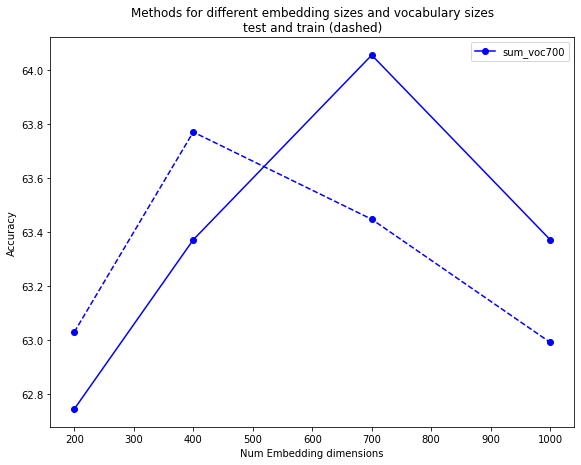

In [24]:
method='sum'

# Vocabulary count
x = [r['emb_dim'] for r in results if r['vocab_count'] == False]
ytr = [r['train_acc'] for r in results if r['vocab_count'] == False]
yte = [r['test_acc'] for r in results if r['vocab_count'] == False]

x, ytr, yte = zip(*sorted(zip(x, ytr, yte)))
y = {'sum_voc700': yte}
y2 = {'sum_voc700': ytr}

few_points_line_plot(x, y, y2=y2,
                     title='Methods for different embedding sizes and vocabulary sizes\ntest and train (dashed)',
                     xlabel='Num Embedding dimensions', 
                     ylabel='Accuracy')